# Spectral noise regression
This notebook develops the method for iteratively regressing the "noise" (stochastic-like) component of the spectral representation. 

You specify a regression function form, e.g. 1/f, or Lorentzian (1/f with knee), and the regression is done by maximizing total data likelihood assuming exponentially distributed power coefficients at each frequency.

---
### More detailed description:

Having seen in the previous notebooks (derivation and metrics) that a portion of the frequency spectrum for neural data very closely follows the hypothesized exponential distribution for signal power (i.e., Fourier coefficients are distributed as 2D complex Gaussian, thus the power, or squared radius, is exponentially distributed). Therefore, we'd like to fit the "background" or "noise" spectrum by only considering those data points that follow the assumption well. However, even for frequencies where there are oscillations, it may operate between a bursting and noise state, meaning that the oscillation is sometimes there, thus boosting the power in that frequency, but otherwise still follows the noise distribution.

Therefore, we don't want to discard frequencies entirely, which is what happens when fitting the average power spectrum while accounting for oscillatory frequencies. We'd like to use as much of the information as possible, including the time points in those frequencies that are in the noise-like state.

To do that, we perform a very simple regression by fitting the entire time-frequency representation to a background function, like the Lorentzian, while assuming that the residual is exponentially distributed at each frequency. It's very much like regular regression, which fits a linear function to data that is normally scattered. The goal is to fit the background function parameters (offset, knee, exponent) while maximizing likelihood (e.g., maximum likelihood). Critically, this procedure does not know anything about "oscillations" or Gaussian peaks, just that data is supposed to be exponentially distributed with the mean following the Lorentzian function.

The initial fits will be poor due to oscillations and other non-noise data points, but one can then compute the likelihood for each data point, and iteratively drop out those with very low likelihood given the current model. Those points are typically either oscillatory burst periods (with higher power) in an otherwise noise-like frequency, or a frequency that's essentially under constant oscillation and thus poorly described by the background function as a whole. So we drop X% of the data points with the lowest likelihood, and re-fit the remaining data iteratively. The bonus thing we get for free is that with the final fit, points marked to have low probability are likely to be oscillatory or other events, thus giving us an oscillation detector for free.

---
Some to dos:
- DONE: collect fit at each step
- there something weird with likelihood being a function of lambda, which is frequency dependent. Ideally it'd be normalized
- when to stop?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from neurodsp import sim, plts, spectral
import numpy as np
from numpy import log10, log
from scipy import random, signal, stats
from scipy.optimize import minimize
from scipy.stats import expon
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA

In [2]:
def lorentzian(f, params):
    A, k, exp = params
    # background function form
    return A/(k+f**exp)

def constant(f, params):
    # return a constant
    return np.ones_like(f)*params

def exp_prob(xs, lambdas):
    # compute likelihood under exponential distribution given lambda (scale param)
    return lambdas*np.exp(-xs*lambdas)

def make_df(f_stft, power):
    # collect spectrogram and flatten into a single vector, with matching frequency axis
    # for easier management
    return pd.DataFrame(np.array([f_stft.repeat(power.shape[1]),power.flatten(), np.nan*np.ones(np.size(power))]).T, 
                        columns=['freq', 'power', 'lh'])

def make_rect(df, feature):
    # return reshaped feature matrix, in original shape time x frequency
    freqs = df['freq'].unique()    
    if type(feature) is str:
        # if return data from dataframe
        return df[feature].values.reshape((len(freqs),-1))
    if len(feature)==len(df):
        # if return arbitrary feature vector
        return feature.reshape((len(freqs),-1))    
    

def compute_logL_flattened(params, fit_func, data_f, data_p):
    # compute point-wise log likelihood for data
    # lambda parameter for exponential is the inverse of the mean
    lmb = 1/fit_func(data_f, params)
    return np.log(exp_prob(data_p,lmb))

def compute_logL_rect(params, fit_func, data_f, data_p):
    # compute log likelihood
    logL = []
    for i_f, f in enumerate(data_f):
        lmb = 1/fit_func(f, params)
        logL.append(np.log(exp_prob(data_p[i_f],lmb)))    
    return np.array(logL)


def total_neglogL(params, fit_func, data_f, data_p):
    # return total negative log likelihood for optimization
    return -compute_logL_flattened(params, fit_func, data_f, data_p).sum()

    

## same stuff but looping over frequencies
# def spectral_logL(params, data_f, data_p):
#     # compute log likelihood
#     A, k, exp = params
#     logL = []
#     for i_f, f in enumerate(data_f):
#         lmb = 1/lorentzian(f, A, k, exp)
#     #     lmb = 1/p.mean()
#         logL.append(np.log10(exp_prob(data_p[i_f],lmb)))
    
#     return np.array(logL)

# def total_neglogL(params, data_f, data_p):
#     return -np.array(spectral_logL(params, data_f, data_p)).sum()


# real data

In [3]:
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
fs = data['srate']
lfp = data['data'][20]
lfp = (lfp-lfp.mean())/np.std(lfp)

# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

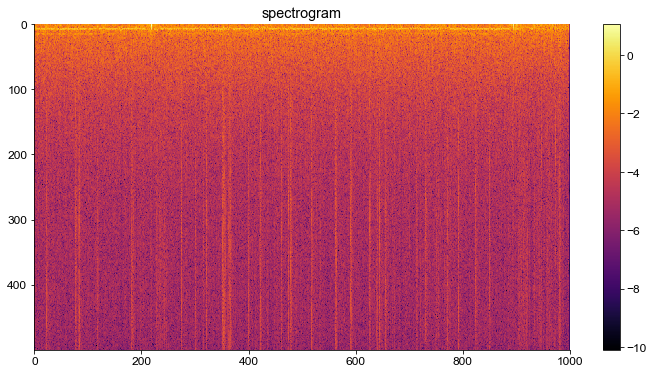

In [4]:
# plot spectrogram
plt.figure(figsize=(12,6))
plt.imshow(np.log10(power[:500,:]), aspect='auto')
plt.title('spectrogram')
plt.colorbar()

# iterative fit
1. fit Lorentzian assuming exponential distributed noise at every frequency, minimize total neg log likelihood
2. compute data likelihood for every square in the spectrogram given the fit model
3. drop the bottom n% of data with the lowest likelihood, back to step 1

In [209]:
def plot_likelihood_update(df_spg, fit_func, params, df_select=None, norm_L=False):
    psd = df_spg.groupby('freq').mean()['power']

    plt.figure(figsize=(16,4))    
    # psds
    plt.subplot(1,4,1)
    plt.loglog(psd.index, psd, label='data')
    
    if df_select is not None:
        psd_trim = df_select.groupby('freq').mean()['power']
        plt.loglog(psd_trim.index, psd_trim, label='data trimmed')

    plt.loglog(psd.index, fit_func(psd.index, params), label='fit')
    plt.legend()

    # plot likelihood
    if norm_L:
        # norm spg to fit
        norm_power = df_spg['power'].values/fit_func(df_spg['freq'], params)
        # evaluate loglikelihood under exp(1)
        logL = compute_logL_flattened(1, constant, df_spg['freq'], norm_power).values
    else:
        logL = compute_logL_flattened(params,fit_func,df_spg['freq'], df_spg['power']).values
    
    plt.subplot(1,4,2)    
    plt.semilogx(df_spg['freq'], logL, 'k.', ms=2, alpha=0.2, label='all')
    plt.ylim([-100,None])
    
    if df_select is not None:
        plt.semilogx(df_select['freq'], logL[df_select.index.values], 'r.', ms=2, alpha=0.2, label='included')
        
        
#     plt.semilogx(df_spg['freq'].unique(), make_rect(df_spg, logL).mean(1), 'k-o', mec='w', label='mean (all)')
    plt.ylabel('log-likelihood');plt.legend()

    plt.subplot(1,2,2)
    plt.imshow(logL.reshape((len(psd),-1)),aspect='auto', vmin=-100)
    plt.colorbar()
    plt.tight_layout()

def iter_fit_noise(f_stft, power, f_bounds, fit_params, norm_L=False, plot_iter=False):
    # make the dataframe
    df_spg = make_df(f_stft, power)
    
    # subselect on freq bounds
    df_select = df_spg[(df_spg['freq']>=f_bounds[0]) & (df_spg['freq']<=f_bounds[1])]
    
    # iterative fit
    fits = []
    for i in range(fit_params['iters']):
        res = minimize(total_neglogL, 
                       fit_params['x0'], 
                       (fit_params['fit_func'], df_select['freq'].values, df_select['power'].values),
                       bounds=fit_params['xbounds'])    
        
        fits.append(res.x)

        # compute point-wise log likelihood & update
        if norm_L:
            # norm spg to fit
            norm_power = df_spg['power'].values/fit_params['fit_func'](df_spg['freq'], fits[-1])
            # evaluate loglikelihood under exp(1)
            logL = compute_logL_flattened(1, constant, df_spg['freq'], norm_power).values
        else:
            logL = compute_logL_flattened(res.x, fit_params['fit_func'], df_spg['freq'], df_spg['power']).values
        df_select.loc[:, 'lh'] = logL[df_select.index.values]
                
        if plot_iter:
            # print and plot
            print('iter:%i'%(i+1), end='| ')
            plot_likelihood_update(df_spg, fit_params['fit_func'], res.x, df_select, norm_L)
            plt.title('iter %i: %.2f percent data:'%(i+1, len(df_select)/len(df_spg)*100))

        # throw out data, refit
        df_select = df_select[df_select['lh'] > np.percentile(df_select['lh'],fit_params['npct'])]

    df_spg['lh'] = np.nan
    df_spg.loc[:, 'lh'] = logL
    return np.array(fits), df_spg


In [210]:
fit_params = {'iters': 20, # number of iterations
             'npct': 1, # percentage drop per iter
              'fit_func': lorentzian, # function to fit
             'x0': (1, 20, 2), # initial guess
             'xbounds':[[0.01,100],[1,100000],[0,5]] # guess on the params
             }

fits_normed, df_spg = iter_fit_noise(f_stft[:200], power[:200,:], (1,200), fit_params, True, False)

In [211]:
fits, df_spg = iter_fit_noise(f_stft[:200], power[:200,:], (1,200), fit_params, False, False)

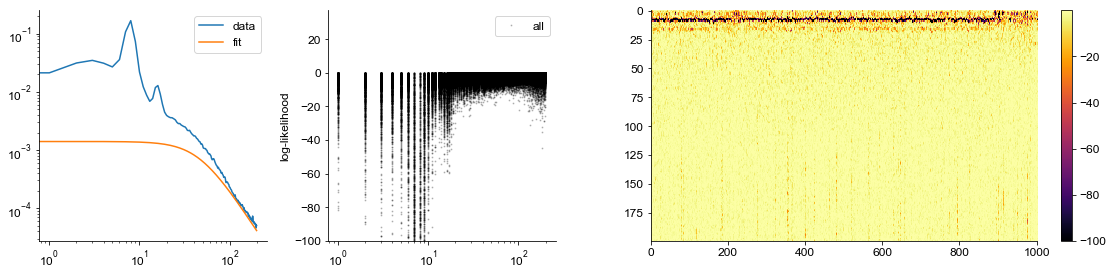

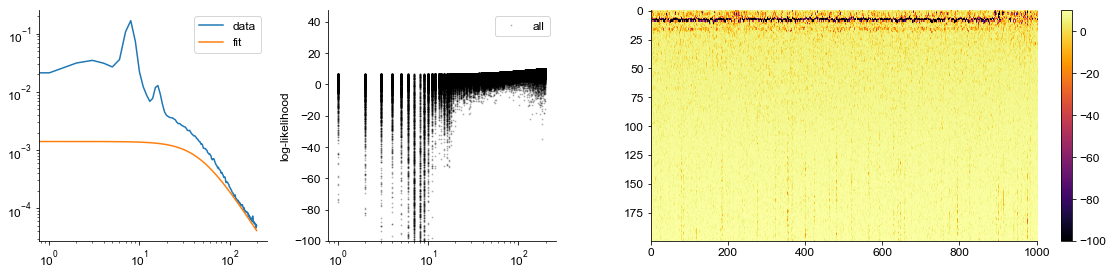

In [212]:
plot_likelihood_update(df_spg, fit_params['fit_func'], fits[-1], df_select=None, norm_L=True)
plot_likelihood_update(df_spg, fit_params['fit_func'], fits[-1], df_select=None, norm_L=False)

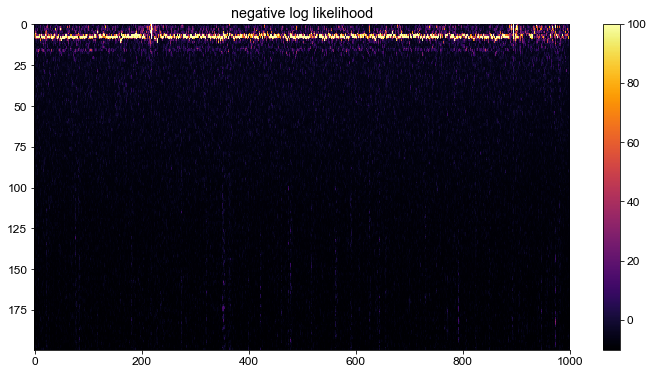

In [215]:
# see point-wise data negative log likelihood for the last fit
# brighter points are non-noise like
psd = make_rect(df_spg, 'power').mean(1)
plt.figure(figsize=(12,6))
plt.imshow(-df_spg['lh'].values.reshape((len(psd),-1)),aspect='auto', vmax=100)
plt.title('negative log likelihood')
plt.colorbar()

# diagnosing infinite log likelihood here
gave up because no point fixing this if we don't optimize over total likelihood

In [216]:
fits_use = fits_normed
# for i in range(20):
#     print(compute_logL_flattened(fits_use[i],lorentzian,df_spg['freq'],df_spg['power']).values.mean())
#     plt.plot(i,compute_logL_flattened(fits_use[i],lorentzian,df_spg['freq'],df_spg['power']).values.mean(),'o')
# # plt.plot(fits_normed[:,1])
# # plt.plot(fits[:,1])

compute_logL_flattened(fits_use[5],lorentzian,df_spg['freq'],df_spg['power']).values[3222]

print(compute_logL_flattened(fits_use[5],lorentzian,df_spg['freq'][3222],df_spg['power'][3222]))
print(df_spg.loc[3220:3226])


log(exp_prob(df_spg.loc[3222]['power'], lorentzian(df_spg.loc[3222]['freq'], fits_use[-1])))
# exp_prob(11.8,lorentzian(3,fits_normed[5]))

# df_spg.loc[3222]['power']

-inf
      freq      power         lh
3220   3.0   0.058302 -34.985499
3221   3.0   0.027655 -13.141869
3222   3.0  11.850220       -inf
3223   3.0   0.098439 -63.592524
3224   3.0   0.128792 -85.226240
3225   3.0   0.088296 -56.363368
3226   3.0   0.036041 -19.119134


-4.823058799992314

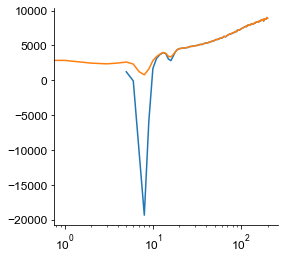

In [217]:
# not sure what I was doing here
psd = make_rect(df_spg, 'power').mean(1)
plt.figure(figsize=(4,4))
plt.plot(make_rect(df_spg, compute_logL_flattened(fits[4], lorentzian, df_spg['freq'], df_spg['power']).values).sum(1))
plt.plot(-len(t_stft)*(np.log(psd)+1))
plt.xscale('log')

# quick comparison with spike PSD

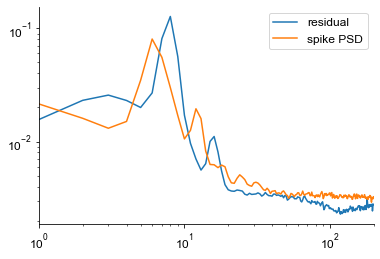

In [218]:
psd = df_spg.groupby('freq').mean()['power']
spks = data['bsp'][:,0:4].sum(1)
f_axis, psd_spk = spectral.compute_spectrum(spks, data['spk_binrate'])
psd_residual = psd/fit_params['fit_func'](psd.index, fits[10])

plt.loglog(psd.index, psd_residual/psd_residual.sum(), label='residual')
plt.loglog(f_axis[:200], psd_spk[:200]/psd_spk[:200].sum(), label='spike PSD')
plt.xlim([1,200])
plt.legend()

# simulations

In [219]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                         'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 8.2}}

sig = sim.sim_combined(n_seconds=180, fs=1000, components=components, component_variances=[1,0])
nperseg=1000
#f_stft, t_stft, stft = signal.stft(sig, fs=1000, window=np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=True)

# compute STFT
f_stft, t_stft, stft = signal.stft(sig, fs=1000, nperseg=nperseg, noverlap=0, boundary=None)

# # compute power and phase
# power, phase = compute_power_phase(stft)
power = abs(stft)**2

In [220]:
# search params
fit_params = {'iters': 10, # number of iterations
             'npct': 1, # percentage drop per iter
              'fit_func': lorentzian, # function to fit
             'x0': (1, 20, 2), # initial guess
             'xbounds':[[0.01,100],[1,100000],[0,5]] # guess on the params
             }
fits, df_spg = iter_fit_noise(f_stft[:200], power[:200,:], (1,200), fit_params, True)

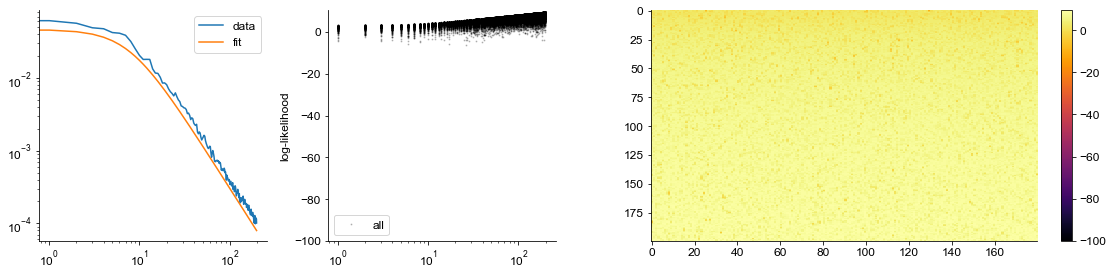

In [222]:
plot_likelihood_update(df_spg, fit_params['fit_func'], fits[-1], df_select=None)

---
# some diagnostic experiments on exponential likelihood

### total log likelihood depends on data mean

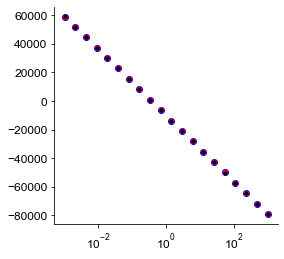

In [5]:
# derived max loglikelihood
def compute_L(x, mean=False):
    n = len(x)
    return -(log(x.mean())+1) if mean else -n*(log(x.mean())+1)

def analytical_L(n,lam,mean=False):
    return -(log(1/lam)+1) if mean else -n*(log(1/lam)+1)

n = 10000
plt.figure(figsize=(4,4))

# step through data means
for x_bar in np.logspace(-3,3,20): 
    x = expon.rvs(loc=0, scale=x_bar, size=n) # draw some random samples
    
    # 3 different ways of computing the log likelihood
    plt.semilogx(x_bar, compute_L(x), 'ob', label='sample L')
    plt.semilogx(x_bar, np.log(exp_prob(x, 1/x_bar)).sum(), 'r*', label='sample L (alt)')
    plt.semilogx(x_bar, -n*(np.log(x_bar)+1),  'k.', label='analytic')
    

as data mean increases, total log likelihood actually decreases (loglinearly), given by the function $-n(log(x_{bar})+1)$.

so the fitting should be done on the normalized distribution, and that total likelihood be returned for optimization, otherwise it will just start tossing out the low-freq stuff and never stop.

### try arbitrary distributions with the same mean

mean: 19.980, total log likelihood: -39947.198,
mean: 19.972, total log likelihood: -39943.165,
mean: 20.000, total log likelihood: -39957.332,
mean: 19.879, total log likelihood: -39896.855,
mean: 19.951, total log likelihood: -39932.679,
mean: 19.875, total log likelihood: -39894.657,


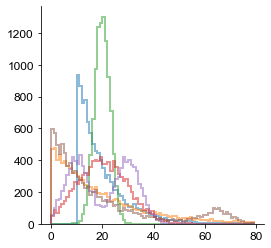

In [6]:
n_samp = 10000
# all mean = 20
x1 = np.random.exponential(scale=10, size=n_samp)+10 # mean-shifted exponential
x2 = np.random.exponential(scale=20, size=n_samp) # scaled exponential
x3 = np.random.normal(loc=20, scale=3, size=n_samp) # gaussian 
x4 = np.random.normal(loc=20, scale=10, size=n_samp) # wider gaussian
x5 = np.hstack([np.random.normal(loc=10, scale=5, size=int(n_samp/2)), np.random.normal(loc=30, scale=5, size=int(n_samp/2))]) # two gaussians
x6 = np.hstack([np.random.exponential(scale=15, size=n_samp-1000), np.random.normal(loc=65, scale=5, size=1000)]) # exponential + gaussian
xs = [x1, x2, x3, x4, x5, x6]

plt.figure(figsize=(4,4))
for x in xs:
    plt.hist(x, np.arange(0,80,1), alpha=0.5, histtype='step', lw=2)
    print('mean: %.3f, total log likelihood: %.3f,'%(x.mean(), compute_L(x)))

### fail
yep. no matter what the distribution looks like, as long as it has the same mean and sample size, the total log likelihood is constant under the exponential model

this means normalizing by mean before computing likelihood is meaningless, and shrinking the distribution by dropping large values will artificially increase likelihood by reducing mean.

---
### does likelihood get worse if you drop data well-described by the distribution
of course total likelihood becomes worse since dropping points will decrease the mean, thus fitting a distribution that makes the high-valued data points even more unlikely. But do the included points become more likely as the model becomes more accurate? This is sort of the fundamental premise of this procedure. 

Also, decreasing the mean (by dropping large values) will increase the likelihood even under the same model but scaled, so the data has to be normalized to have the same mean first at each iteration.

In [7]:
def kl_unitexp_power(power, p_bins=None):
    if p_bins is None: p_bins = np.arange(0,5,0.1)
    bin_width = p_bins[1]-p_bins[0]
    ref_expdist = stats.expon(0,1).pdf(p_bins[:-1]+bin_width/2)
    return np.array([stats.entropy(np.histogram(pw/pw.mean(), p_bins)[0], ref_expdist) for pw in power])

def compute_kl_unitexp(x, p_bins=None):
    if p_bins is None: p_bins = np.arange(0,5,0.1)
    bin_width = p_bins[1]-p_bins[0]
    ref_expdist = stats.expon(0,1).pdf(p_bins[:-1]+bin_width/2)
    return stats.entropy(np.histogram(x/x.mean(), p_bins)[0], ref_expdist)

# development code

In [8]:
# LL, SCV, KL = [], [], []

# # compute LL on subsequently less data
# x_sorted = x.sort()
# drop_pct = np.arange(0, 20, 1)
# for dp in drop_pct:
#     x_curr = x[:len(x)-int(len(x)*dp/100)]
#     if norm_by_mean:
#         LL.append(compute_L(x_curr/x_curr.mean(), mean=norm_by_n))
#     else:
#         LL.append(compute_L(x_curr, mean=norm_by_n))
    
#     SCV.append(x_curr.std()/x_curr.mean())
#     KL.append(kl_unitexp_power([x_curr/x_curr.mean()]))

    
# plt.figure(figsize=(15,3))


# plt.subplot(1,5,2)
# pdf, bins, _ = plt.hist(x, n_bins, color='k', alpha=0.5, density=True); plt.yscale('log')
# plt.xlim([0,None]); plt.ylim([0,None])

# plt.subplot(1,5,1)
# cdf = np.cumsum(pdf/pdf.sum())
# plt.fill_between(bins[1:], counts/counts.max(), counts.min()/counts.max(), color='k', alpha=0.5)
# plt.scatter(bins[1:], cdf, c=fracs, s=50); 
# plt.plot(bins[1:], cdf, 'k-', alpha=0.9); 
# plt.xlim([0,None]); plt.ylim([0,1])

# plt.subplot(1,5,3)
# plt.plot(drop_pct, LL, 'ko'); 
# plt.xlabel('drop percentage'); plt.title('total log likelihood')

# plt.subplot(1,5,4)
# plt.plot(drop_pct, abs(log(SCV)), 'ko'); 
# plt.xlabel('drop percentage'); plt.title('abs logSCV')

# plt.subplot(1,5,5)
# plt.plot(drop_pct, KL, 'ko'); 
# plt.xlabel('drop percentage'); plt.title('KL from exp(1)');
# plt.tight_layout()

In [299]:
def profile_freq(x, drop_pct=None, norm_by_mean=False, norm_by_n=False):
    if drop_pct is None: drop_pct = np.arange(0, 20, 1)    

    # compute LL, SCV, KL on subsequently less data
    LL, SCV, KL = [], [], []
    x_sorted = np.sort(x)
    for dp in drop_pct:
        # grab remaining data
        x_curr = x_sorted[:len(x_sorted)-int(len(x_sorted)*dp/100)]
        # compute LL
        if norm_by_mean:
            LL.append(compute_L(x_curr/x_curr.mean(), mean=norm_by_n))
        else:
            LL.append(compute_L(x_curr, mean=norm_by_n))
        # compute SCV and KL
        SCV.append(x_curr.std()/x_curr.mean())
        KL.append(compute_kl_unitexp(x_curr/x_curr.mean()))
        
    # compute minimum
    loss = KL*abs(log10(SCV))
    min_pct = drop_pct[np.argmin(loss)]
    min_ind = len(x)-int(len(x)*min_pct/100)
    x_thresh = x_sorted[-1] if min_ind==len(x) else x_sorted[min_ind]
    return drop_pct, LL, SCV, KL, (min_pct,x_thresh)


def plot_freq_profile(x, n_bins, profile):
    # get profile
    drop_pct, LL, SCV, KL, thresh = profile
    
    # plot log histogram
    plt.subplot(1,5,2)
    pdf, bins, _ = plt.hist(x, n_bins, color='k', alpha=0.5, density=True);
    plt.axvline(thresh[1], color='r')
    plt.yscale('log'); plt.xlim([0,None]); plt.ylim([0,None])
    plt.xlabel('data value'); plt.ylabel('log pdf')

    # plot pdf and cdf
    plt.subplot(1,5,1)
    cdf = np.cumsum(pdf/pdf.sum())
    plt.fill_between(bins[1:], pdf/pdf.max(), color='k', alpha=0.5)
    plt.scatter(bins[1:], cdf, c=cdf, s=50); 
    plt.plot(bins[1:], cdf, 'k-', alpha=0.9); 
    plt.axvline(thresh[1], color='r')
    plt.xlim([0,None]); plt.ylim([0,1])
    plt.xlabel('data value'); plt.ylabel('pdf & cdf')
    
    # plot LL, SCV, KL
    plt.subplot(1,5,3)
    plt.plot(drop_pct, LL, 'ko', alpha=0.8); 
    plt.axvline(thresh[0], color='r')
    plt.xlabel('drop percentage'); plt.ylabel('log likelihood')

    plt.subplot(1,5,4)
    plt.plot(drop_pct, abs(log10(SCV)), 'ko', alpha=0.8, label='abs(logSCV)');
    plt.plot(drop_pct, (log10(SCV)), 'bo', alpha=0.8, label='logSCV');
    plt.axhline(0, color='k', ls='--'); plt.axvline(thresh[0], color='r'); plt.legend()
    plt.xlabel('drop percentage'); plt.ylabel('logSCV')

    plt.subplot(1,5,5)
    plt.plot(drop_pct, KL, 'ko', alpha=0.8);
    plt.axvline(thresh[0], color='r')
    plt.xlabel('drop percentage'); plt.ylabel('KL from exp(1)');
    plt.tight_layout()

empirical: -1.0000, theoretical: -1.0000, analytical: -1.0000


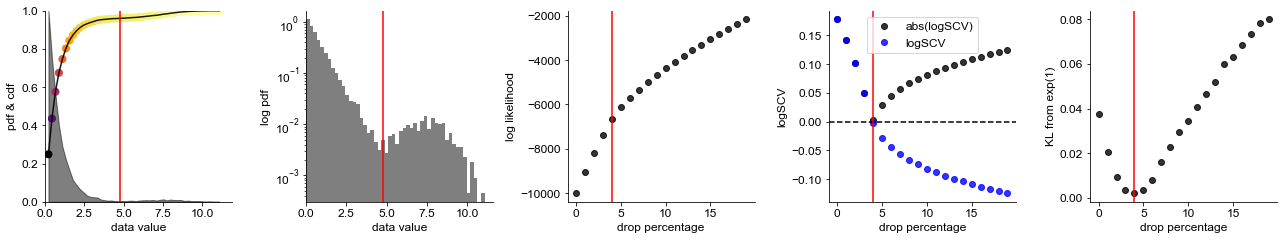

In [300]:
norm_by_mean = False
norm_by_n = False

# simulate 10k samples under exp(5)
x_mean = 1
n_samp = 10000
n_outlier = 400
# x = expon.rvs(scale=x_mean,size=n_samp)

# exponential + gaussian
x = np.hstack([np.random.exponential(scale=20, size=n_samp-n_outlier), np.random.normal(loc=200, scale=40, size=n_outlier)])
x = x/x.mean()

lam = 1/x.mean()
# print a few ways of computing mean logL
print('empirical: %.4f, theoretical: %.4f, analytical: %.4f'%(compute_L(x, mean=True), log(exp_prob(x, 1/x_mean)).mean(), analytical_L(len(x),1/x_mean,mean=True)))

f_profile = profile_freq(x)
drop_pct, LL, SCV, KL, x_thresh = f_profile
plt.figure(figsize=(18,3.5))
plot_freq_profile(x, 50, f_profile)

### log-likelihood increases but SCV and KL deviates from target
at 5% drop, we should recover optimal fit to the exponential distribution, which is not reflected in the log likelihood but in SCV (abs logSCV = 0) and minKL

---
# second try at iterative fit
- fit mean using napp
- drop based on likelihood
- track scv and KL

alternatively, sweep through per-frequency to drop points to optimize SCV and KL. Explore this second option first below.

In [425]:
from fooof import FOOOF

def compute_power_stats(x):
    n = len(x)
    psd = x.mean()
    scv = x.std()/psd
    ll = compute_L(x, mean=True)
    kl = compute_kl_unitexp(x/psd)
    return n, psd, scv, kl, ll

def compute_power_stats_all(power_fit, mask):
    # n, psd, scv, kl, ll
    p_stats = []
    for f in range(power_fit.shape[0]):
        p_stats.append(compute_power_stats(power_fit[f,mask[f,:]]))

    return np.array(p_stats).T

def plot_p_stats_quick(f_fit, p_stats, c=None):
    for i, pp in enumerate(p_stats):
        plt.subplot(1,4,i+1)
        plt.loglog(f_fit, pp, alpha=0.5, color=c)


In [384]:
# use real data again
# rat LFP
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
fs = data['srate']
lfp = data['data'][1]
lfp = (lfp-lfp.mean())/np.std(lfp)

# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

In [455]:
# monkey ECoG
datafolder = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session1/'
chan = 20 #20 #45 #20 #127
data_exmp = io.loadmat(datafolder+'ECoG_ch%i.mat'%chan, squeeze_me=True)['ECoGData_ch%i'%chan]
cond = io.loadmat(datafolder+'Condition.mat', squeeze_me=True)
data = data_exmp[cond['ConditionIndex'][0]:cond['ConditionIndex'][1]]
fs = 1000

f_stft, t_stft, stft = signal.stft(data[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

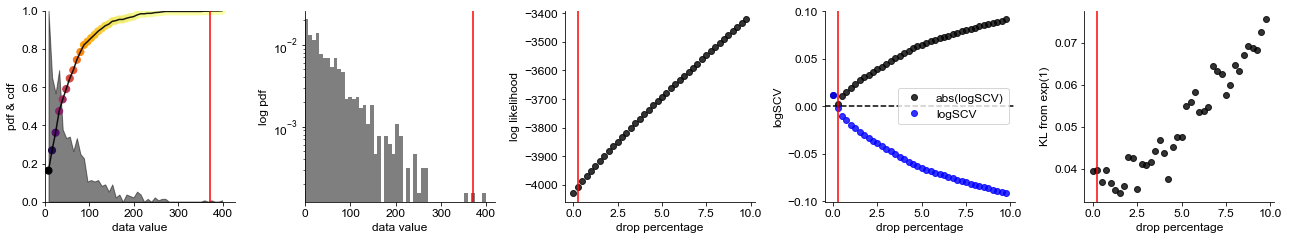

In [456]:
freq = 40
x = power[freq, 30:-30]
drop_pct = np.arange(0,10,0.25)

f_profile = profile_freq(x, drop_pct)
drop_pct, LL, SCV, KL, x_thresh = f_profile
plt.figure(figsize=(18,3.5))

plot_freq_profile(x, 50, f_profile)

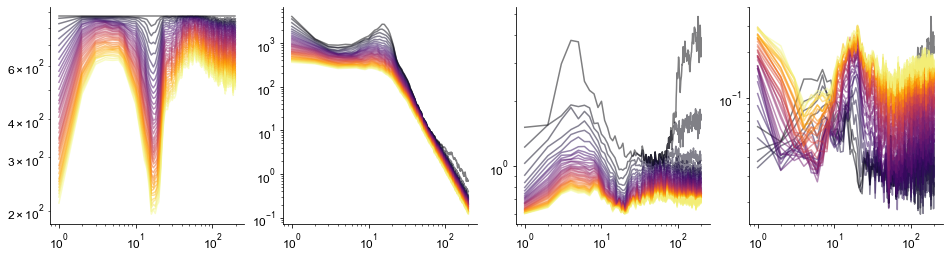

In [457]:
drop_pct = np.arange(0,40,1)
color = plt.cm.inferno(np.linspace(0,1,len(drop_pct)+1))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

fit_inds = np.arange(1,200)
power_fit = power[fit_inds,:]
f_fit = f_stft[fit_inds]
ff = FOOOF(max_n_peaks=0, aperiodic_mode='knee', verbose=False)

plt.figure(figsize=(16,4))
p_stats = compute_power_stats_all(power_fit, np.ones_like(power_fit, dtype=bool))
n, psd, scv, kl, ll = p_stats
plot_p_stats_quick(f_fit, p_stats[:4])
params_all = []

# iterate
for dp in drop_pct[1:]:
    # fit
    ff.fit(f_fit, psd)
    params = ff.get_params('aperiodic_params')
    params[0] = 10**params[0] # fooof convention is that offset is logged
    params_all.append(params)

    # evaluate log likelihood under the mean, which is just the fit model

    # this computes unnormalized likelihood
#     logL = compute_logL_rect(params, lorentzian, f_fit, power_fit)
    
    # this computes likelihood under the normalized distribution
    logL = np.exp(-power_fit/lorentzian(f_fit,params)[:,None])

    # compute mask based on drop percentage
    mask = logL>np.percentile(logL, dp)

    # loop through freqs to compute psd, scv, KL, logL on remaining data
    p_stats_curr = compute_power_stats_all(power_fit, mask)
    n, psd, scv, kl, ll = p_stats_curr
    # collect
    p_stats = np.dstack((p_stats, p_stats_curr))
    plot_p_stats_quick(f_fit, p_stats_curr[:4])    
    
params_all = np.array(params_all)

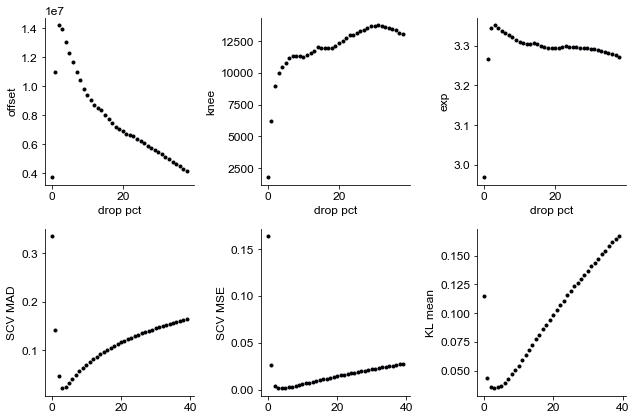

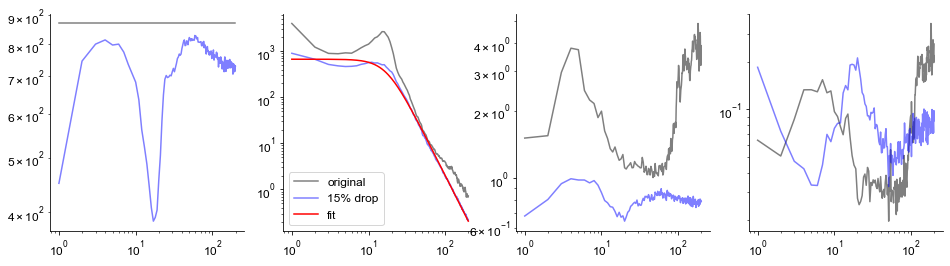

In [460]:
plt.figure(figsize=(9,6))
params_labels = ['offset','knee','exp']
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.plot(drop_pct[:-1], params_all[:,i], '.')
    plt.xlabel('drop pct'); plt.ylabel(params_labels[i])


plt.subplot(2,3,4)
plt.plot(drop_pct, (abs(log10(p_stats[2,:,:]))).mean(0), '.')
plt.ylabel('SCV MAD')
plt.subplot(2,3,5)
plt.plot(drop_pct, ((log10(p_stats[2,:,:])**2)).mean(0), '.')
plt.ylabel('SCV MSE')
plt.subplot(2,3,6)
plt.plot(drop_pct, (p_stats[3,:,:]).mean(0), '.')
plt.ylabel('KL mean')
plt.tight_layout()

dp = 15
plt.figure(figsize=(16,4))
plot_p_stats_quick(f_fit, p_stats[:4,:,0], c='k')
plot_p_stats_quick(f_fit, p_stats[:4,:,dp], c='b')
plt.subplot(1,4,2)
plt.plot(f_fit, lorentzian(f_fit,params_all[dp]), 'r-')
plt.legend(['original', '%i%% drop'%dp, 'fit'])

---
# truncated exponential experiment

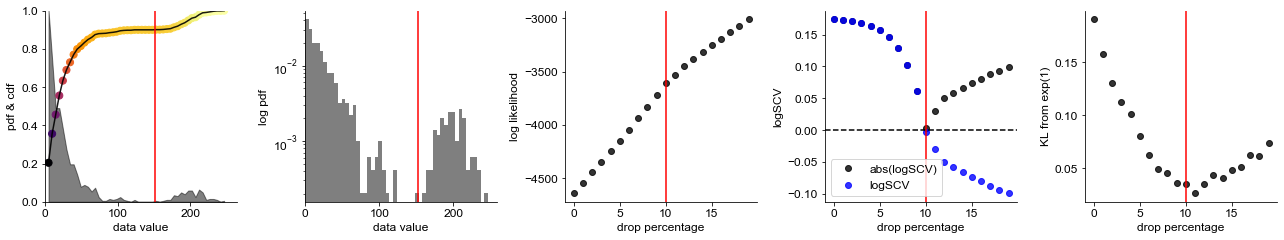

In [382]:
from scipy.stats import truncexpon

# simulate 10k samples
x_mean = 20
n_samp = 1000
n_outlier = 100

# exponential + gaussian
x = np.hstack([np.random.exponential(scale=x_mean, size=n_samp-n_outlier), 
               np.random.normal(loc=200, scale=20, size=n_outlier)])

f_profile = profile_freq(x)
drop_pct, LL, SCV, KL, x_thresh = f_profile
plt.figure(figsize=(18,3.5))
plot_freq_profile(x, 50, f_profile)

the other problem here is stoppage: dropping outright and re-estimate SCV and MI under an exponential is not exactly what you wanna do here. instead, you should fit a TRUNCATED exponential to the remaining points.

except, the param estimation is horseshit, for example, the truncexpon mean estimate for this is

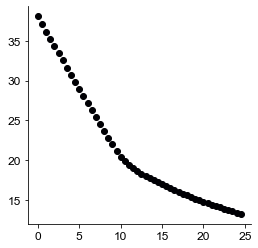

In [383]:
x_sorted = np.sort(x)
drop_pct = np.arange(0,25,.5)
params = []
for dp in drop_pct:
    x_curr = x_sorted[:len(x_sorted)-int(len(x_sorted)*dp/100)]
    params.append(truncexpon.fit(x_curr, floc=0, f0=x_curr[-1]))
    
plt.figure(figsize=(4,4))
plt.plot(drop_pct, np.array(params)[:,2], 'o')